<a href="https://colab.research.google.com/github/PivotTableProphet/Bank-Transaction-Fraud-Detection-Prediction-/blob/main/MIS444_MAIN_Project_01(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*LIBRARY IMPORT FOR STARTING THE PROJECT AND DISPLAY*

In [1]:
# Step 0: Imports & config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# XGBoost (optional but included)
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None  # If not installed, we’ll skip it gracefully

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")


*LOADING DATA TO SEE IN DATAFRAME*

In [2]:
# Step 1: Load data
CSV_PATH = "Bank_Transaction_Fraud_Detection.csv"  # change if needed
df = pd.read_csv(CSV_PATH)

print(df.shape)
print(df.head(3))
print(df.dtypes)


(200000, 24)
                            Customer_ID    Customer_Name  Gender  Age  \
0  d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e       Osha Tella    Male   60   
1  7c14ad51-781a-4db9-b7bd-67439c175262  Hredhaan Khosla  Female   51   
2  3a73a0e5-d4da-45aa-85f3-528413900a35   Ekani Nazareth    Male   20   

         State                City                Bank_Branch Account_Type  \
0       Kerala  Thiruvananthapuram  Thiruvananthapuram Branch      Savings   
1  Maharashtra              Nashik              Nashik Branch     Business   
2        Bihar           Bhagalpur           Bhagalpur Branch      Savings   

                         Transaction_ID Transaction_Date  ...  \
0  4fa3208f-9e23-42dc-b330-844829d0c12c       23-01-2025  ...   
1  c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c       11-01-2025  ...   
2  e41c55f9-c016-4ff3-872b-cae72467c75c       25-01-2025  ...   

  Merchant_Category  Account_Balance Transaction_Device  \
0        Restaurant         74557.27    Voice Assistant   
1 

*CHECKED BASIC THINGS FOR INSTANCE MISSING VALLUES AND OTHERS*

In [3]:
# Step 2: Basic checks
print("Missing values per column:\n", df.isnull().sum().sort_values(ascending=False).head(10))
print("\nClass balance (Is_Fraud):\n", df['Is_Fraud'].value_counts(normalize=True))

Missing values per column:
 Customer_ID         0
Customer_Name       0
Gender              0
Age                 0
State               0
City                0
Bank_Branch         0
Account_Type        0
Transaction_ID      0
Transaction_Date    0
dtype: int64

Class balance (Is_Fraud):
 Is_Fraud
0    0.94956
1    0.05044
Name: proportion, dtype: float64


*FRAUD DETECTION IN CLASS SHOW*

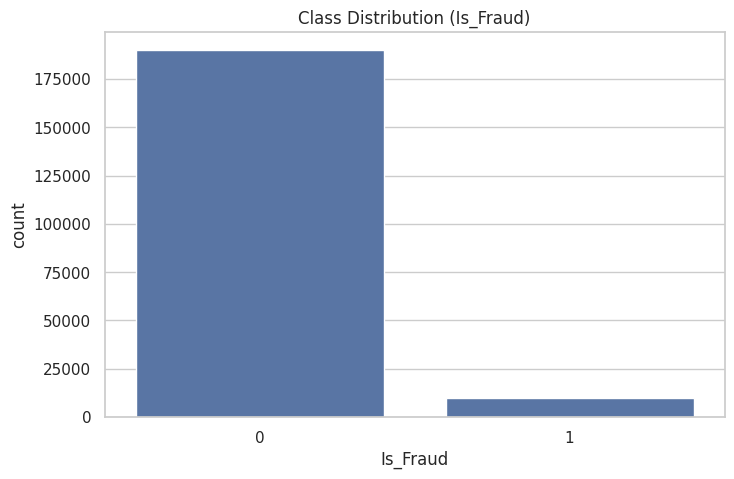

In [4]:
# Bar chart of target
sns.countplot(x='Is_Fraud', data=df)
plt.title("Class Distribution (Is_Fraud)")
plt.show()

*HEATMAP*

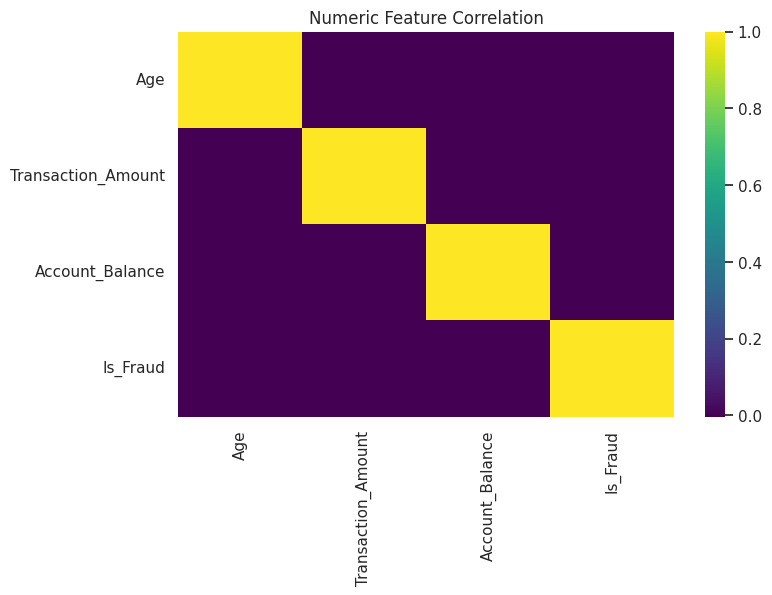

In [5]:
# Simple numeric correlation heatmap (numeric cols only)
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
corr = df[num_cols].corr()
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Numeric Feature Correlation")
plt.show()

*EXTRACTING DATES AND ADDING COLUMNS*

In [6]:
# Step 3: Date/time feature extraction
def extract_datetime_features(frame: pd.DataFrame) -> pd.DataFrame:
    df2 = frame.copy()
    # Parse date (dayfirst=True for DD-MM-YYYY)
    df2["Transaction_Date_dt"] = pd.to_datetime(df2["Transaction_Date"], dayfirst=True, errors="coerce")
    # Parse time
    df2["Transaction_Time_dt"] = pd.to_datetime(df2["Transaction_Time"], format="%H:%M:%S", errors="coerce").dt.time

    # New features
    df2["Txn_DayOfWeek"] = df2["Transaction_Date_dt"].dt.dayofweek
    df2["Txn_Month"]     = df2["Transaction_Date_dt"].dt.month

    # Hour from time; if parsing failed, fallback to 0
    def time_to_hour(t):
        try:
            return t.hour
        except:
            return 0
    df2["Txn_Hour"] = df2["Transaction_Time_dt"].apply(time_to_hour)

    # Drop raw strings (keep original date/time dt columns out as well)
    df2.drop(columns=["Transaction_Date", "Transaction_Time", "Transaction_Date_dt", "Transaction_Time_dt"], inplace=True, errors="ignore")
    return df2

df = extract_datetime_features(df)
print("Engineered columns added. Current columns:", df.columns.tolist())


Engineered columns added. Current columns: ['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Amount', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Account_Balance', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud', 'Transaction_Currency', 'Customer_Contact', 'Transaction_Description', 'Customer_Email', 'Txn_DayOfWeek', 'Txn_Month', 'Txn_Hour']


In [7]:
#4) Drop IDs / PII / single-value columns
# =========================
drop_cols = [
    "Customer_ID", "Customer_Name", "Transaction_ID", "Merchant_ID",
    "Customer_Contact", "Customer_Email", "Transaction_Currency",
    "Transaction_Description"  # drop for baseline; can freq-encode if you want to keep it
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

*DATASET SPLIT*

In [8]:
# 5) Split features/target
# =========================
TARGET = "Is_Fraud"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

pos_ratio = (y_train == 1).mean()
neg_ratio = 1 - pos_ratio
scale_pos_weight = (neg_ratio / pos_ratio) if pos_ratio > 0 else 1.0
print(f"Train class ratio: fraud={pos_ratio:.4f}, non-fraud={neg_ratio:.4f}, scale_pos_weight≈{scale_pos_weight:.2f}")


Train class ratio: fraud=0.0504, non-fraud=0.9496, scale_pos_weight≈18.83


*ONE HOT ENCODING*

In [9]:
#6) Column typing + encoders

numeric_features = [c for c in ["Age","Transaction_Amount","Account_Balance",
                                "Txn_Hour","Txn_DayOfWeek","Txn_Month"]
                    if c in X_train.columns]

low_card_cats = [c for c in ["Gender","Account_Type","Transaction_Type",
                             "Merchant_Category","Device_Type","Transaction_Device"]
                 if c in X_train.columns]

high_card_cats = [c for c in ["State","City","Bank_Branch","Transaction_Location"]
                  if c in X_train.columns]

print("Numeric:", numeric_features)
print("Low-card cats (OneHot):", low_card_cats)
print("High-card cats (FreqEnc):", high_card_cats)

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.maps_ = {}
        self.columns_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.columns_ = X.columns
        self.maps_ = {}
        for col in self.columns_:
            vc = X[col].value_counts(normalize=True)
            self.maps_[col] = vc.to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.columns_:
            mapping = self.maps_.get(col, {})
            X[col] = X[col].map(mapping).fillna(0.0)
        return X.values

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
freq_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("freq",    FrequencyEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num",    numeric_transformer, numeric_features),
        ("onehot", onehot_transformer,  low_card_cats),
        ("freq",   freq_transformer,    high_card_cats),
    ],
    remainder="drop"
)

Numeric: ['Age', 'Transaction_Amount', 'Account_Balance', 'Txn_Hour', 'Txn_DayOfWeek', 'Txn_Month']
Low-card cats (OneHot): ['Gender', 'Account_Type', 'Transaction_Type', 'Merchant_Category', 'Device_Type', 'Transaction_Device']
High-card cats (FreqEnc): ['State', 'City', 'Bank_Branch', 'Transaction_Location']


*FEATURE SELECTION*

In [10]:
# Feature Selection (SelectKBest with f_classif)
# =========================
from sklearn.feature_selection import f_classif

use_feature_selection = True
feature_selector = SelectKBest(score_func=f_classif, k=80)  # adjust k to your dataset size

In [11]:
# CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [12]:
# Small helper to show test metrics
def evaluate_on_test(fitted_pipeline, model_name: str):
    y_proba = fitted_pipeline.predict_proba(X_test)[:,1] if hasattr(fitted_pipeline, "predict_proba") else None
    y_pred  = fitted_pipeline.predict(X_test)
    print(f"\n[{model_name}] Test classification report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=model_name)
        plt.plot([0,1],[0,1],'--',linewidth=1)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()

*SMOTE CODING*

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # Import Pipeline from imblearn
from sklearn.linear_model import LogisticRegression # Example model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define a pipeline that includes preprocessing, SMOTE, and a model
# You can replace LogisticRegression with any other classifier you want to use after SMOTE
model_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Include the preprocessor
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42)) # Placeholder model - replace as needed
])

# Fit the pipeline on the original training data (preprocessing and SMOTE will be applied within the pipeline)
model_pipeline.fit(X_train, y_train)

# Now evaluate the pipeline (preprocessing and model prediction will be applied within the pipeline)
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1] if hasattr(model_pipeline, 'predict_proba') else None

# You can then evaluate the performance using metrics like classification_report, confusion_matrix, roc_auc_score etc.
print("Model performance after SMOTE:")
print(classification_report(y_test, y_pred, digits=4))
if y_proba is not None:
    print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

Model performance after SMOTE:
              precision    recall  f1-score   support

           0     0.9486    0.5042    0.6584     37982
           1     0.0495    0.4856    0.0898      2018

    accuracy                         0.5033     40000
   macro avg     0.4990    0.4949    0.3741     40000
weighted avg     0.9032    0.5033    0.6297     40000

Test ROC-AUC: 0.49512530556047124


*MODEL TESTING LOGISTIC REGRSSSION
*

Logistic Regression Accuracy: 0.5149
              precision    recall  f1-score   support

           0     0.9497    0.5165    0.6691     37982
           1     0.0506    0.4846    0.0916      2018

    accuracy                         0.5149     40000
   macro avg     0.5001    0.5006    0.3803     40000
weighted avg     0.9043    0.5149    0.6400     40000

Confusion matrix:
 [[19618 18364]
 [ 1040   978]]
Test ROC-AUC: 0.49754660532695083

[DEBUG] Class balance (y):
Is_Fraud
0    0.94956
1    0.05044
Name: proportion, dtype: float64

[DEBUG] Shapes:
X_train_processed: (160000, 50)  X_test_processed: (40000, 50)

[DEBUG] y_train length: 160000  y_test length: 40000

[DEBUG] Predicted probability distribution (first 20):
[0.5385776  0.51801273 0.51243463 0.49388972 0.48603938 0.4875937
 0.49324928 0.50409186 0.50004468 0.49556477 0.50199927 0.50758513
 0.52554186 0.48129726 0.5292025  0.50605423 0.52252401 0.52262151
 0.50985166 0.52076978]

Summary stats of predicted probabilities:

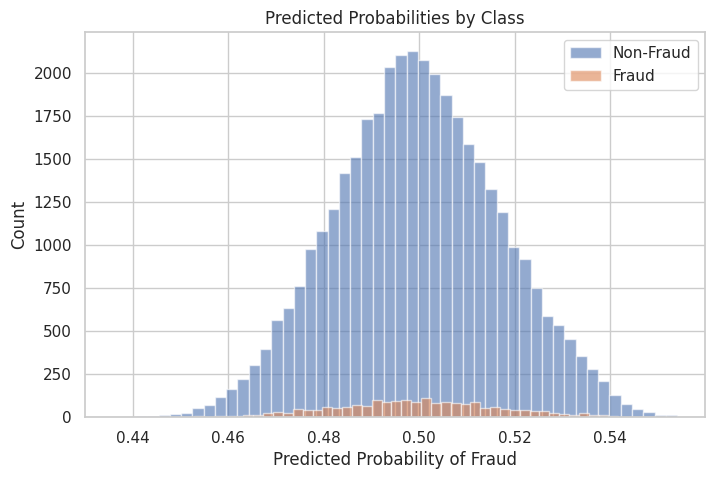

In [14]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   # handles imbalance
    solver="liblinear",        # supports L1 and L2
    C=1.0                      # regularization strength
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

logreg_model.fit(X_train_processed, y_train)

y_pred = logreg_model.predict(X_test_processed)
y_proba = logreg_model.predict_proba(X_test_processed)[:,1]

# accuracy + report (matches your print style)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# 1) Class balance
print("\n[DEBUG] Class balance (y):")
print(y.value_counts(normalize=True))

# 2) Check shapes
print("\n[DEBUG] Shapes:")
print("X_train_processed:", X_train_processed.shape,
      " X_test_processed:", X_test_processed.shape)

# 3) Make sure target aligns
print("\n[DEBUG] y_train length:", len(y_train), " y_test length:", len(y_test))

# 4) Prediction probability distribution
print("\n[DEBUG] Predicted probability distribution (first 20):")
print(y_proba[:20])
print("\nSummary stats of predicted probabilities:")
print(pd.Series(y_proba).describe())

# 5) Predicted class distribution
print("\n[DEBUG] Prediction class distribution:")
print(pd.Series(y_pred).value_counts())

# 6) Histogram of predicted probabilities by class
import matplotlib.pyplot as plt
plt.hist(y_proba[y_test==0], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(y_proba[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.xlabel("Predicted Probability of Fraud")
plt.ylabel("Count")
plt.title("Predicted Probabilities by Class")
plt.legend()
plt.show()

*XGBOOST*

XGBoost Accuracy: 0.7545

XGBoost Results:
              precision    recall  f1-score   support

           0     0.9487    0.7838    0.8584     37982
           1     0.0473    0.2022    0.0767      2018

    accuracy                         0.7545     40000
   macro avg     0.4980    0.4930    0.4676     40000
weighted avg     0.9032    0.7545    0.8190     40000

Confusion matrix:
 [[29771  8211]
 [ 1610   408]]
Test ROC-AUC: 0.4956077924658798

[DEBUG] First 20 predicted probabilities:
[0.15339085 0.38908333 0.3258578  0.46579984 0.5001727  0.13704506
 0.42567375 0.3731729  0.3982197  0.34828696 0.5375055  0.510694
 0.3448343  0.38141716 0.500825   0.5158379  0.37392035 0.4797052
 0.42243096 0.47182643]

[DEBUG] Summary stats of predicted probabilities:
count    40000.000000
mean         0.418561
std          0.103190
min          0.022447
25%          0.357246
50%          0.428307
75%          0.490242
max          0.858788
dtype: float64

[DEBUG] Prediction class distribution:


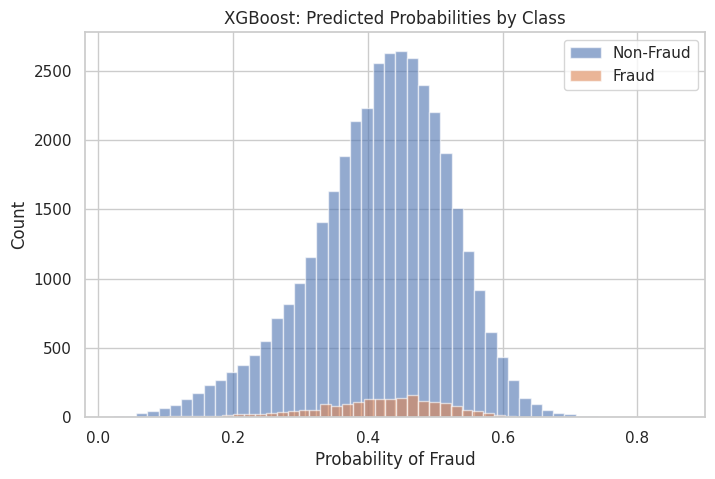

In [15]:
from xgboost import XGBClassifier

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

# Train
xgb_model.fit(X_train_processed, y_train)

# Predict
y_pred = xgb_model.predict(X_test_processed)
y_proba = xgb_model.predict_proba(X_test_processed)[:,1]

# Evaluation
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nXGBoost Results:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# Debugging
print("\n[DEBUG] First 20 predicted probabilities:")
print(y_proba[:20])
print("\n[DEBUG] Summary stats of predicted probabilities:")
print(pd.Series(y_proba).describe())
print("\n[DEBUG] Prediction class distribution:")
print(pd.Series(y_pred).value_counts())

plt.hist(y_proba[y_test==0], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(y_proba[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.title("XGBoost: Predicted Probabilities by Class")
plt.xlabel("Probability of Fraud"); plt.ylabel("Count")
plt.legend(); plt.show()




*NAIVE BAYES*

Naive Bayes Accuracy: 0.9496

Naive Bayes Results:
              precision    recall  f1-score   support

           0     0.9496    1.0000    0.9741     37982
           1     0.0000    0.0000    0.0000      2018

    accuracy                         0.9496     40000
   macro avg     0.4748    0.5000    0.4871     40000
weighted avg     0.9016    0.9496    0.9250     40000

Confusion matrix:
 [[37982     0]
 [ 2018     0]]
Test ROC-AUC: 0.4981150243876932

[DEBUG] First 20 predicted probabilities:
[0.16049242 0.05752307 0.05347896 0.03611786 0.05583909 0.03851838
 0.05014193 0.04364135 0.08796033 0.04698424 0.06487107 0.07443899
 0.13862597 0.03125048 0.15200516 0.04498362 0.10396194 0.08373743
 0.04381991 0.14458981]

[DEBUG] Summary stats of predicted probabilities:
count    40000.000000
mean         0.057504
std          0.033628
min          0.006842
25%          0.035304
50%          0.045108
75%          0.072914
max          0.179899
dtype: float64

[DEBUG] Prediction class dis

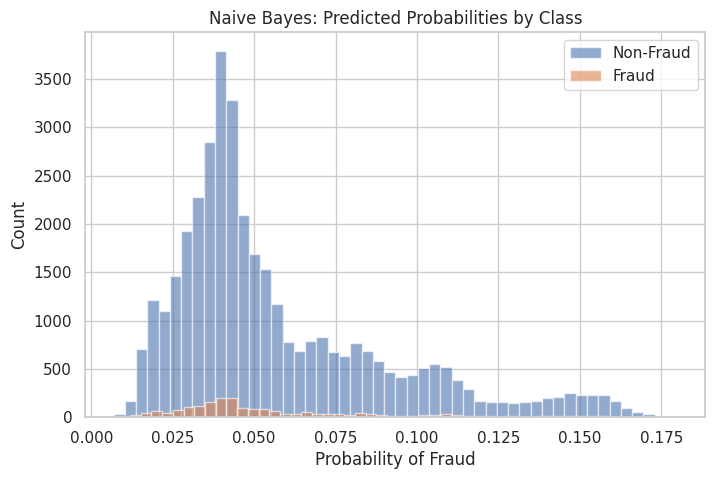

In [16]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

# Train
nb_model.fit(X_train_processed, y_train)

# Predict
y_pred = nb_model.predict(X_test_processed)
y_proba = nb_model.predict_proba(X_test_processed)[:,1]

# Evaluation
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nNaive Bayes Results:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# Debugging
print("\n[DEBUG] First 20 predicted probabilities:")
print(y_proba[:20])
print("\n[DEBUG] Summary stats of predicted probabilities:")
print(pd.Series(y_proba).describe())
print("\n[DEBUG] Prediction class distribution:")
print(pd.Series(y_pred).value_counts())

plt.hist(y_proba[y_test==0], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(y_proba[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.title("Naive Bayes: Predicted Probabilities by Class")
plt.xlabel("Probability of Fraud"); plt.ylabel("Count")
plt.legend(); plt.show()


*RANDOM FOREST CLASSIFIER*

Random Forest Accuracy: 0.9496

Random Forest Results:
              precision    recall  f1-score   support

           0     0.9496    1.0000    0.9741     37982
           1     0.0000    0.0000    0.0000      2018

    accuracy                         0.9496     40000
   macro avg     0.4748    0.5000    0.4871     40000
weighted avg     0.9016    0.9496    0.9250     40000

Confusion matrix:
 [[37982     0]
 [ 2018     0]]
Test ROC-AUC: 0.5091391094493198

[DEBUG] First 20 predicted probabilities:
[0.04       0.03333333 0.05666667 0.07       0.07333333 0.02
 0.07       0.06       0.05666667 0.07       0.04333333 0.03333333
 0.05666667 0.03666667 0.07       0.02666667 0.09333333 0.04666667
 0.04333333 0.07333333]

[DEBUG] Summary stats of predicted probabilities:
count    40000.000000
mean         0.051159
std          0.021228
min          0.000000
25%          0.036667
50%          0.050000
75%          0.063333
max          0.286667
dtype: float64

[DEBUG] Prediction class distr

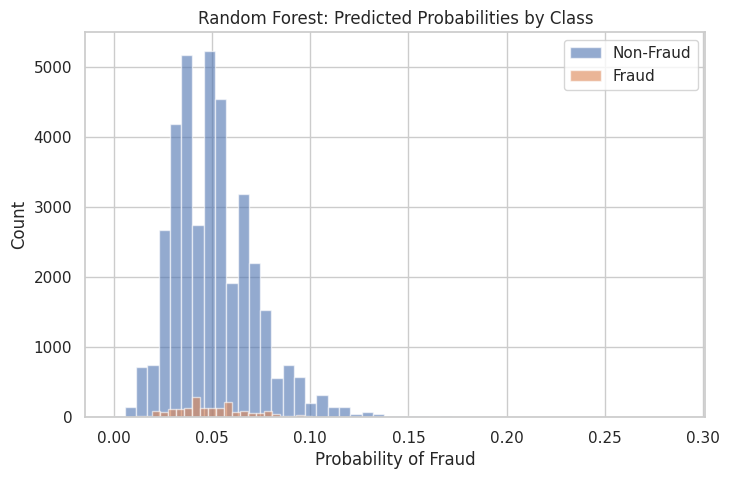

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

# Train
rf_model.fit(X_train_processed, y_train)

# Predict
y_pred = rf_model.predict(X_test_processed)
y_proba = rf_model.predict_proba(X_test_processed)[:,1]

# Evaluation
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# Debugging
print("\n[DEBUG] First 20 predicted probabilities:")
print(y_proba[:20])
print("\n[DEBUG] Summary stats of predicted probabilities:")
print(pd.Series(y_proba).describe())
print("\n[DEBUG] Prediction class distribution:")
print(pd.Series(y_pred).value_counts())

plt.hist(y_proba[y_test==0], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(y_proba[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.title("Random Forest: Predicted Probabilities by Class")
plt.xlabel("Probability of Fraud"); plt.ylabel("Count")
plt.legend(); plt.show()


*DECISION TREE CLASSIFIER*

Decision Tree Accuracy: 0.8982

Decision Tree Results:
              precision    recall  f1-score   support

           0     0.9496    0.9428    0.9462     37982
           1     0.0515    0.0585    0.0548      2018

    accuracy                         0.8982     40000
   macro avg     0.5005    0.5006    0.5005     40000
weighted avg     0.9043    0.8982    0.9012     40000

Confusion matrix:
 [[35808  2174]
 [ 1900   118]]
Test ROC-AUC: 0.5006180487455353

[DEBUG] First 20 predicted probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[DEBUG] Summary stats of predicted probabilities:
count    40000.000000
mean         0.057300
std          0.232418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

[DEBUG] Prediction class distribution:
0    37708
1     2292
Name: count, dtype: int64


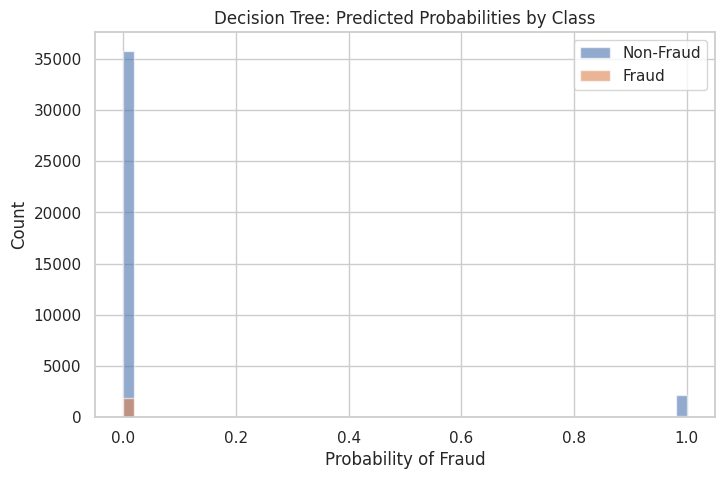

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

# Train
dt_model.fit(X_train_processed, y_train)

# Predict
y_pred = dt_model.predict(X_test_processed)
y_proba = dt_model.predict_proba(X_test_processed)[:,1]

# Evaluation
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nDecision Tree Results:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# Debugging
print("\n[DEBUG] First 20 predicted probabilities:")
print(y_proba[:20])
print("\n[DEBUG] Summary stats of predicted probabilities:")
print(pd.Series(y_proba).describe())
print("\n[DEBUG] Prediction class distribution:")
print(pd.Series(y_pred).value_counts())

plt.hist(y_proba[y_test==0], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(y_proba[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.title("Decision Tree: Predicted Probabilities by Class")
plt.xlabel("Probability of Fraud"); plt.ylabel("Count")
plt.legend(); plt.show()


*KNN*

KNN Accuracy: 0.9496

KNN Results:
              precision    recall  f1-score   support

           0     0.9496    1.0000    0.9741     37982
           1     0.0000    0.0000    0.0000      2018

    accuracy                         0.9496     40000
   macro avg     0.4748    0.5000    0.4871     40000
weighted avg     0.9016    0.9496    0.9250     40000

Confusion matrix:
 [[37982     0]
 [ 2018     0]]
Test ROC-AUC: 0.4921596513898216

[DEBUG] First 20 predicted probabilities:
[0.   0.   0.08 0.   0.04 0.08 0.08 0.   0.   0.   0.   0.04 0.08 0.04
 0.08 0.04 0.04 0.04 0.08 0.04]

[DEBUG] Summary stats of predicted probabilities:
count    40000.000000
mean         0.049995
std          0.043545
min          0.000000
25%          0.000000
50%          0.040000
75%          0.080000
max          0.280000
dtype: float64

[DEBUG] Prediction class distribution:
0    40000
Name: count, dtype: int64


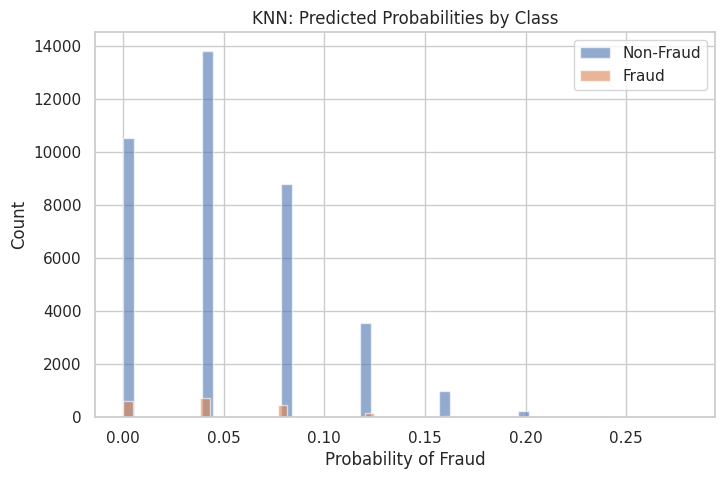

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)

# Train
knn_model.fit(X_train_processed, y_train)

# Predict
y_pred = knn_model.predict(X_test_processed)
y_proba = knn_model.predict_proba(X_test_processed)[:,1]

# Evaluation
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nKNN Results:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# Debugging
print("\n[DEBUG] First 20 predicted probabilities:")
print(y_proba[:20])
print("\n[DEBUG] Summary stats of predicted probabilities:")
print(pd.Series(y_proba).describe())
print("\n[DEBUG] Prediction class distribution:")
print(pd.Series(y_pred).value_counts())

plt.hist(y_proba[y_test==0], bins=50, alpha=0.6, label="Non-Fraud")
plt.hist(y_proba[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.title("KNN: Predicted Probabilities by Class")
plt.xlabel("Probability of Fraud"); plt.ylabel("Count")
plt.legend(); plt.show()


*CROSS VALIDATION ( LOGISTIC REGRESSION)*

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd


# Step 1: Load data
CSV_PATH = "Bank_Transaction_Fraud_Detection.csv"  # change if needed
df = pd.read_csv(CSV_PATH)

# Step 3: Date/time feature extraction
def extract_datetime_features(frame: pd.DataFrame) -> pd.DataFrame:
    df2 = frame.copy()
    # Parse date (dayfirst=True for DD-MM-YYYY)
    df2["Transaction_Date_dt"] = pd.to_datetime(df2["Transaction_Date"], dayfirst=True, errors="coerce")
    # Parse time
    df2["Transaction_Time_dt"] = pd.to_datetime(df2["Transaction_Time"], format="%H:%M:%S", errors="coerce").dt.time

    # New features
    df2["Txn_DayOfWeek"] = df2["Transaction_Date_dt"].dt.dayofweek
    df2["Txn_Month"]     = df2["Transaction_Date_dt"].dt.month

    # Hour from time; if parsing failed, fallback to 0
    def time_to_hour(t):
        try:
            return t.hour
        except:
            return 0
    df2["Txn_Hour"] = df2["Transaction_Time_dt"].apply(time_to_hour)

    # Drop raw strings (keep original date/time dt columns out as well)
    df2.drop(columns=["Transaction_Date", "Transaction_Time", "Transaction_Date_dt", "Transaction_Time_dt"], inplace=True, errors="ignore")
    return df2

df = extract_datetime_features(df)

#4) Drop IDs / PII / single-value columns
# =========================
drop_cols = [
    "Customer_ID", "Customer_Name", "Transaction_ID", "Merchant_ID",
    "Customer_Contact", "Customer_Email", "Transaction_Currency",
    "Transaction_Description"  # drop for baseline; can freq-encode if you want to keep it
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")


# 5) Split features/target
# =========================
TARGET = "Is_Fraud"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Re-define the preprocessor and necessary components
numeric_features = [c for c in ["Age","Transaction_Amount","Account_Balance",
                                "Txn_Hour","Txn_DayOfWeek","Txn_Month"]
                    if c in X_train.columns]

low_card_cats = [c for c in ["Gender","Account_Type","Transaction_Type",
                             "Merchant_Category","Device_Type","Transaction_Device"]
                 if c in X_train.columns]

high_card_cats = [c for c in ["State","City","Bank_Branch","Transaction_Location"]
                  if c in X_train.columns]

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.maps_ = {}
        self.columns_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.columns_ = X.columns
        self.maps_ = {}
        for col in self.columns_:
            vc = X[col].value_counts(normalize=True)
            self.maps_[col] = vc.to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.columns_:
            mapping = self.maps_.get(col, {})
            X[col] = X[col].map(mapping).fillna(0.0)
        return X.values

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
freq_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("freq",    FrequencyEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num",    numeric_transformer, numeric_features),
        ("onehot", onehot_transformer,  low_card_cats),
        ("freq",   freq_transformer,    high_card_cats),
    ],
    remainder="drop"
)


# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Logistic Regression Model
logreg_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   # handles imbalance
    solver="liblinear",        # supports L1 and L2
    C=1.0                      # regularization strength
)

# Cross-validation (5-fold)
cv_scores = cross_val_score(logreg_model, X_train_processed, y_train, cv=5, scoring="roc_auc", n_jobs=-1)

print(f"Logistic Regression (5-fold CV) ROC-AUC: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")

Logistic Regression (5-fold CV) ROC-AUC: Mean = 0.4999, Std = 0.0031


*CROSS VALIDATION ( DECISION TREE )*

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Decision Tree Model
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=10,           # Optional: add depth limit for better generalization
    min_samples_split=2     # Optional: prevent overfitting
)

# Cross-validation (5-fold)
cv_scores = cross_val_score(dt_model, X_train_processed, y_train, cv=5, scoring="roc_auc", n_jobs=-1)

print(f"Decision Tree (5-fold CV) ROC-AUC: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")


Decision Tree (5-fold CV) ROC-AUC: Mean = 0.5019, Std = 0.0075


*CROSS VALIDATION (KNN)*

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)

# Cross-validation (5-fold)
cv_scores = cross_val_score(knn_model, X_train_processed, y_train, cv=5, scoring="roc_auc", n_jobs=-1)

print(f"KNN (5-fold CV) ROC-AUC: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")


KNN (5-fold CV) ROC-AUC: Mean = 0.5022, Std = 0.0032


*CROSS VALIDATION (RANDOM FOREST CLASSIFIER)*

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

# Cross-validation (5-fold)
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=5, scoring="roc_auc", n_jobs=-1)

print(f"Random Forest (5-fold CV) ROC-AUC: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")


Random Forest (5-fold CV) ROC-AUC: Mean = 0.5002, Std = 0.0032


*CROSS VALIDATION ( NAIVE BAYES )*

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import numpy as np

# Naive Bayes Model
nb_model = GaussianNB()

# Cross-validation (5-fold)
Xtr_nb = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
Xte_nb = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

cv_scores = cross_val_score(nb_model, Xtr_nb, y_train, cv=5, scoring="roc_auc", n_jobs=-1)

print(f"Naive Bayes (5-fold CV) ROC-AUC: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")


Naive Bayes (5-fold CV) ROC-AUC: Mean = 0.4980, Std = 0.0050


*CROSS VALIDATION (XGBOOST)*

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# XGBoost Model
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

# Cross-validation (5-fold)
cv_scores = cross_val_score(xgb_model, X_train_processed, y_train, cv=5, scoring="roc_auc", n_jobs=-1)

print(f"XGBoost (5-fold CV) ROC-AUC: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")


XGBoost (5-fold CV) ROC-AUC: Mean = 0.4965, Std = 0.0053


*GRIDSEARCH (RANDOM FOREST CLASSIFIER)*

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")

# Define the smaller hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],  # Smaller number of trees
    'max_depth': [None, 10],      # Limit depth of trees
    'min_samples_split': [2],     # Reduce options for min_samples_split
    'class_weight': ['balanced']  # Use one option for class_weight
}

# Set up GridSearchCV (using 3-fold cross-validation)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_processed, y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters found
print(f"Best Hyperparameters: {grid_search.best_params_}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [27]:
# After tuning, evaluate the model on the test set
y_pred = best_rf_model.predict(X_test_processed)
y_proba = best_rf_model.predict_proba(X_test_processed)[:, 1]

# Print final results
print(f"Random Forest with Best Hyperparameters Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))


Random Forest with Best Hyperparameters Accuracy: 0.9496
              precision    recall  f1-score   support

           0     0.9496    1.0000    0.9741     37982
           1     0.0000    0.0000    0.0000      2018

    accuracy                         0.9496     40000
   macro avg     0.4748    0.5000    0.4871     40000
weighted avg     0.9016    0.9496    0.9250     40000

Test ROC-AUC: 0.4955022250120147


*PERFORMANCE MEASUREMENT [ROC CURVE, ROC-AUC SCORE]*

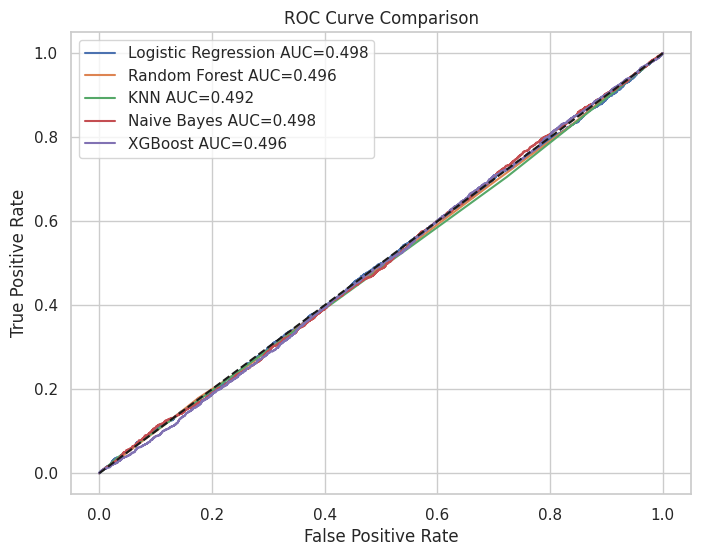

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split


# Step 1: Load data (if not already loaded in this session)
try:
    df
except NameError:
    CSV_PATH = "Bank_Transaction_Fraud_Detection.csv"
    df = pd.read_csv(CSV_PATH)

    # Step 3: Date/time feature extraction
    def extract_datetime_features(frame: pd.DataFrame) -> pd.DataFrame:
        df2 = frame.copy()
        df2["Transaction_Date_dt"] = pd.to_datetime(df2["Transaction_Date"], dayfirst=True, errors="coerce")
        df2["Txn_DayOfWeek"] = df2["Transaction_Date_dt"].dt.dayofweek
        df2["Txn_Month"]     = df2["Transaction_Date_dt"].dt.month
        df2["Txn_Hour"] = pd.to_datetime(df2["Transaction_Time"], format="%H:%M:%S", errors="coerce").dt.hour.fillna(0).astype(int)
        df2.drop(columns=["Transaction_Date", "Transaction_Time", "Transaction_Date_dt"], inplace=True, errors="ignore")
        return df2
    df = extract_datetime_features(df)

    #4) Drop IDs / PII / single-value columns
    drop_cols = [
        "Customer_ID", "Customer_Name", "Transaction_ID", "Merchant_ID",
        "Customer_Contact", "Customer_Email", "Transaction_Currency",
        "Transaction_Description"
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

    # 5) Split features/target
    TARGET = "Is_Fraud"
    X = df.drop(columns=[TARGET])
    y = df[TARGET].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Re-define the preprocessor and necessary components (assuming these haven't changed)
    numeric_features = [c for c in ["Age","Transaction_Amount","Account_Balance",
                                    "Txn_Hour","Txn_DayOfWeek","Txn_Month"]
                        if c in X_train.columns]
    low_card_cats = [c for c in ["Gender","Account_Type","Transaction_Type",
                                 "Merchant_Category","Device_Type","Transaction_Device"]
                     if c in X_train.columns]
    high_card_cats = [c for c in ["State","City","Bank_Branch","Transaction_Location"]
                      if c in X_train.columns]

    class FrequencyEncoder(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.maps_ = {}
            self.columns_ = None
        def fit(self, X, y=None):
            X = pd.DataFrame(X).copy()
            self.columns_ = X.columns
            self.maps_ = {}
            for col in self.columns_:
                vc = X[col].value_counts(normalize=True)
                self.maps_[col] = vc.to_dict()
            return self
        def transform(self, X):
            X = pd.DataFrame(X).copy()
            for col in self.columns_:
                mapping = self.maps_.get(col, {})
                X[col] = X[col].map(mapping).fillna(0.0)
            return X.values

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    onehot_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    freq_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("freq",    FrequencyEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num",    numeric_transformer, numeric_features),
            ("onehot", onehot_transformer,  low_card_cats),
            ("freq",   freq_transformer,    high_card_cats),
        ],
        remainder="drop"
    )

    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train, y_train)
    X_test_processed = preprocessor.transform(X_test)


# Define and fit models (re-fitting here for self-containment if needed)
# You can comment out models you don't want to compare
logreg_model = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", C=1.0)
logreg_model.fit(X_train_processed, y_train)

# Assuming best_rf_model was obtained from a previous GridSearchCV cell
# If not, define a default RandomForestClassifier here:
# best_rf_model = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")
# best_rf_model.fit(X_train_processed, y_train)

knn_model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
knn_model.fit(X_train_processed, y_train)

nb_model = GaussianNB()
# GaussianNB requires dense input, but preprocessor already outputs dense
nb_model.fit(X_train_processed, y_train)


# Assuming xgb_model was defined and fitted previously
# If not, define and fit here (example params):
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgb_model = XGBClassifier(
    n_estimators=300, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, random_state=42,
    eval_metric="logloss", use_label_encoder=False, n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train_processed, y_train)


# Define models dictionary with the fitted models
models = {
    "Logistic Regression": logreg_model,
    # Use the best_rf_model if available, otherwise use the default rf_model defined above
    "Random Forest": best_rf_model if 'best_rf_model' in locals() else RandomForestClassifier(random_state=42, class_weight="balanced_subsample").fit(X_train_processed, y_train),
    "KNN": knn_model,
    "Naive Bayes": nb_model,
    "XGBoost": xgb_model
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    # Preprocessed data is already dense, no need for toarray()
    y_pred_prob = model.predict_proba(X_test_processed)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} AUC={auc:.3f}")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

*RESULT INTERPRETATION*

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_processed)          # predictions
    y_prob = model.predict_proba(X_test_processed)[:,1]  # predicted probabilities

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, auc])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1 Score","AUC"])
results_df.set_index("Model", inplace=True)

print(results_df)


                     Accuracy  Precision    Recall  F1 Score       AUC
Model                                                                 
Logistic Regression  0.514900   0.050564  0.484638  0.091573  0.497547
Random Forest        0.949550   0.000000  0.000000  0.000000  0.495502
KNN                  0.949550   0.000000  0.000000  0.000000  0.492160
Naive Bayes          0.949550   0.000000  0.000000  0.000000  0.498115
XGBoost              0.754475   0.047337  0.202180  0.076713  0.495608
